In [1]:
import postgres
import pandas as pd
import numpy as np
import datetime
import requests
import time
import hmac
import hashlib
import urllib
import urllib2
import simplejson as json
import base64
import matplotlib.pyplot as plt
from requests.auth import AuthBase

%matplotlib inline
plt.style.use('ggplot')

In [2]:
COINS = [
    'BTC',
    'ETH',
    'LTC', 
    'XMR', # Monero
    'DASH', # Dash
    'ZEC', # ZCash
    'DCR', # Decred
    'SC', # Siacoin
    'FCT', # Factom
    'GNT', # Golem
    'REP', # Augur
    'SJCX', # Storjcoin
    'XEM', # NEM
    'MLN', # Melonport
    'ICN', # Iconomi
    'MKR', # Maker
]

In [3]:
BTC_ADDRESSES = [
]

In [4]:
ETH_ADDRESSES = [
]

In [5]:
DASH_ADDRESSES = [
]

In [6]:
ZCASH_ADDRESSES = [
]

In [7]:
TOKEN_CONTRACT_ADDRESSES = {
    'GNT': '0xa74476443119a942de498590fe1f2454d7d4ac0d',
    'ICN': '0x888666CA69E0f178DED6D75b5726Cee99A87D698',
    'MLN': '0xBEB9eF514a379B997e0798FDcC901Ee474B6D9A1',
    'REP': '0x48c80F1f4D53D5951e5D5438B54Cba84f29F32a5',
    'MKR': '0xc66ea802717bfb9833400264dd12c2bceaa34a6d',
}

In [8]:
CB_API_KEY = 
CB_API_SECRET = 
CB_API_VERSION = '2015-09-29'

GDAX_API_KEY = 
GDAX_API_SECRET = 
GDAX_API_PASS = 

POLO_API_KEY = 
POLO_API_SECRET = 

CB_URL = 'https://api.coinbase.com/v2/'
GDAX_URL = 'https://api.gdax.com/'

In [9]:
class CoinbaseAuth():
    def __init__(self, api_key, secret_key, version):
        self.api_key = api_key
        self.api_secret = secret_key
        self.api_version = version
        
    def __call__(self, request):
        timestamp = str(int(time.time()))
        message = timestamp + request.method + request.path_url + (request.body or '')
        signature = hmac.new(self.api_secret, message, hashlib.sha256).hexdigest()
        
        request.headers.update({
            'CB-ACCESS-KEY': self.api_key,
            'CB-ACCESS-SIGN': signature,
            'CB-ACCESS-TIMESTAMP': timestamp,
            'CB-VERSION': self.api_version
        })
    
        return request

In [10]:
class GDAXAuth(AuthBase):
    def __init__(self, api_key, secret_key, passphrase):
        self.api_key = api_key
        self.secret_key = secret_key
        self.passphrase = passphrase

    def __call__(self, request):
        timestamp = str(time.time())
        message = timestamp + request.method + request.path_url + (request.body or '')
        hmac_key = base64.b64decode(self.secret_key)
        signature = hmac.new(hmac_key, message, hashlib.sha256)
        signature_b64 = signature.digest().encode('base64').rstrip('\n')

        request.headers.update({
            'CB-ACCESS-SIGN': signature_b64,
            'CB-ACCESS-TIMESTAMP': timestamp,
            'CB-ACCESS-KEY': self.api_key,
            'CB-ACCESS-PASSPHRASE': self.passphrase,
            'Content-Type': 'application/json'
        })
        
        return request

In [11]:
class PoloAuth:
    def __init__(self, APIKey, Secret):
        self.APIKey = APIKey
        self.Secret = Secret
        
    def createTimeStamp(datestr, format="%Y-%m-%d %H:%M:%S"):
        return time.mktime(time.strptime(datestr, format))
 
    def post_process(self, before):
        after = before
 
        # Add timestamps if there isnt one but is a datetime
        if('return' in after):
            if(isinstance(after['return'], list)):
                for x in xrange(0, len(after['return'])):
                    if(isinstance(after['return'][x], dict)):
                        if('datetime' in after['return'][x] and 'timestamp' not in after['return'][x]):
                            after['return'][x]['timestamp'] = float(self.createTimeStamp(after['return'][x]['datetime']))
                           
        return after
 
    def api_query(self, command, req={}):
 
        if(command == "returnTicker" or command == "return24Volume"):
            ret = urllib2.urlopen(urllib2.Request('https://poloniex.com/public?command=' + command))
            return json.loads(ret.read())
        elif(command == "returnOrderBook"):
            ret = urllib2.urlopen(urllib2.Request('https://poloniex.com/public?command=' + command + '&currencyPair=' + str(req['currencyPair'])))
            return json.loads(ret.read())
        elif(command == "returnMarketTradeHistory"):
            ret = urllib2.urlopen(urllib2.Request('https://poloniex.com/public?command=' + "returnTradeHistory" + '&currencyPair=' + str(req['currencyPair'])))
            return json.loads(ret.read())
        else:
            req['command'] = command
            req['nonce'] = int(time.time()*1000)
            post_data = urllib.urlencode(req)
 
            sign = hmac.new(self.Secret, post_data, hashlib.sha512).hexdigest()
            headers = {
                'Sign': sign,
                'Key': self.APIKey
            }
 
            ret = urllib2.urlopen(urllib2.Request('https://poloniex.com/tradingApi', post_data, headers))
            jsonRet = json.loads(ret.read())
            return self.post_process(jsonRet)
    
    def returnTicker(self):
        return self.api_query("returnTicker")

    def returnBalances(self):
        return self.api_query('returnBalances')

In [12]:
def coinbase_balances(balances, coinbase_json):
    for _ in [_ for _ in coinbase_json if _['currency'] in COINS]:
        currency = _['currency']
        balance = float(_['balance']['amount'])
        if balance > 0:
            balances[currency].append(balance)
    
    return balances

In [13]:
def gdax_balances(balances, gdax_json):
    for _ in [_ for _ in gdax_json if _['currency'] in COINS]:
        currency = _['currency']
        balance = float(_['balance'])
        if balance > 0:
            balances[currency].append(balance)
            
    return balances

In [14]:
def polo_balances(balances, polo_json):
    for _ in [_ for _ in polo_json.iteritems() if _[0] in COINS]:
        currency = _[0]
        balance = float(_[1])
        if balance > 0:
            balances[currency].append(balance)
    
    return balances

In [15]:
def blockchain_balances(balances, currency, url, addresses, unit):
    for _ in addresses:
        r = requests.get(url + _)
        balance = r.json() / float(unit)
        if balance > 0:
            balances[currency].append(balance)
    
    return balances

In [16]:
def zcash_balances(balances):
    for _ in ZCASH_ADDRESSES:
        url = 'https://api.zcha.in/v2/mainnet/accounts/'
        r = requests.get(url + _)
        r = r.json()
        balance = float(r['balance'])
        if balance > 0:
            balances['ZEC'].append(balance)
        
    return balances

In [17]:
def eth_balances(balances):
    string = ''
    for _ in ETH_ADDRESSES:
        string += _ + ','

    url = 'https://api.etherscan.io/api?module=account&action=balancemulti&address=' + string[:-1] + '&tag=latest'
    r = requests.get(url)
    r = r.json()['result']

    for _ in r:
        balance = float(_['balance']) / float(1000000000000000000)
        if balance > 0:
            balances['ETH'].append(balance)
    
    return balances

In [18]:
def eth_token_balances(balances):
    for _ in TOKEN_CONTRACT_ADDRESSES.keys():
        currency = _
        contract_address = TOKEN_CONTRACT_ADDRESSES[_]

        for eth_address in ETH_ADDRESSES:
            url = 'https://api.etherscan.io/api?module=account&action=tokenbalance&contractaddress=' + \
                  contract_address + '&address=' + eth_address + '&tag=latest'
            r = requests.get(url)
            balance = float(r.json()['result']) / float(1000000000000000000)

            if balance > 0:
                balances[currency].append(balance)
        
    return balances

In [19]:
def exchange_rates():
    # Obtains BTC_XXX crypto-crypto rates from Poloniex
    exchange_rates = {}
    exchange_pairs = []
    for coin in [_ for _ in COINS if _ != 'BTC']:
        exchange_pairs.append('BTC_' + coin)
    
    polo_rates = polo_auth.returnTicker()
    for pair in [_ for _ in polo_rates if _ in exchange_pairs]:
        exchange_rates[pair] = polo_rates[pair]['last']

    btc_rate = requests.get('https://api.gdax.com/products/BTC-USD/ticker')
    exchange_rates['BTC-USD'] = str(btc_rate.json()['price'])

    # Iconomi and Melonport are not listed on Polo
    kraken_response = requests.get('https://api.kraken.com/0/public/Ticker?pair=ICNXBT,MLNXBT')
    kraken_rates = kraken_response.json()['result']
    for pair in kraken_rates:
        formatted_pair = str(pair[1:4] + '_' + pair[5:])
        exchange_rates[formatted_pair] = str(kraken_rates[pair]['p'][0])
    
    return exchange_rates

## Grab Exchange Data

In [20]:
coinbase_auth = CoinbaseAuth(CB_API_KEY, CB_API_SECRET, CB_API_VERSION)
coinbase_request = requests.get(CB_URL + 'accounts', auth=coinbase_auth)
coinbase_json = coinbase_request.json()

In [21]:
gdax_auth = GDAXAuth(GDAX_API_KEY, GDAX_API_SECRET, GDAX_API_PASS)
gdax_request = requests.get(GDAX_URL + 'accounts', auth=gdax_auth)
gdax_json = gdax_request.json()

In [22]:
polo_auth = PoloAuth(POLO_API_KEY, POLO_API_SECRET)
polo_json = polo_auth.returnBalances()

## Exchange Balances

In [52]:
balances = {}
for coin in COINS:
    balances[coin] = []

In [41]:
balances = coinbase_balances(balances, coinbase_json['data'])
balances = gdax_balances(balances, gdax_json)
balances = polo_balances(balances, polo_json)

## Blockchain Balances

In [42]:
btc_url = 'https://blockchain.info/q/addressbalance/'
dash_url = 'https://explorer.dash.org/chain/Dash/q/addressbalance/'
balances = blockchain_balances(balances, 'BTC', btc_url, BTC_ADDRESSES, 100000000)
balances = blockchain_balances(balances, 'DASH', dash_url, DASH_ADDRESSES, 1)
balances = zcash_balances(balances)
balances = eth_balances(balances)
balances = eth_token_balances(balances)

In [53]:
for currency in balances.keys():
    balances[currency] = sum(balances[currency])

## USD Value

In [27]:
def exchange_rates():
    exchange_rates = {}
    exchange_pairs = []
    for coin in [_ for _ in COINS if _ != 'BTC']:
        exchange_pairs.append('BTC_' + coin)

    polo_rates = polo_auth.returnTicker()
    for pair in [_ for _ in polo_rates if _ in exchange_pairs]:
        exchange_rates[pair] = polo_rates[pair]['last']

    btc_rate = requests.get('https://api.gdax.com/products/BTC-USD/ticker')
    exchange_rates['BTC_USD'] = str(btc_rate.json()['price'])

    kraken_response = requests.get('https://api.kraken.com/0/public/Ticker?pair=ICNXBT,MLNXBT')
    kraken_rates = kraken_response.json()['result']
    for pair in kraken_rates:
        formatted_pair = str('BTC_' + pair[1:4])
        exchange_rates[formatted_pair] = str(kraken_rates[pair]['p'][0])
        
    exchange_rates['BTC_MKR'] = exchange_rates['BTC_ETH']
    
    return exchange_rates

In [28]:
def get_btc_value(row, exchange_rates):
    currency = row.get('Currency')
    balance = float(row.get('Balance'))
    
    if currency == 'BTC':
        return balance
    
    exchange_rate = float(exchange_rates[('BTC_' + currency)])
    return balance * exchange_rate

In [29]:
def get_usd_value(row, exchange_rates):
    currency = row.get('Currency')
    balance = float(row.get('BTC_Value'))
    usd_rate = float(exchange_rates['BTC_USD'])
    
    return balance * usd_rate    

In [30]:
def pct_of_portfolio(row, usd_sum):
    currency = row.get('Currency')
    balance = float(row.get('USD_Value'))
    
    return balance / float(usd_sum)

In [31]:
rates = exchange_rates()

In [54]:
df = pd.DataFrame.from_dict(balances, orient='index')
df = df.reset_index()
df.rename(columns={'index': 'Currency', 0: 'Balance'}, inplace=True)

In [55]:
df['BTC_Value'] = df.apply(lambda row: get_btc_value(row, rates), axis=1)
df['USD_Value'] = df.apply(lambda row: get_usd_value(row, rates), axis=1)

In [56]:
portfolio_value = df['USD_Value'].sum()
df['pct'] = df.apply(lambda row: pct_of_portfolio(row, portfolio_value), axis=1)

ZeroDivisionError: ('float division by zero', u'occurred at index 0')

In [57]:
df.sort_values('USD_Value', ascending=False, inplace=True)
df.set_index(['Currency'], inplace=True)

## Final Data

In [58]:
df

,Balance,BTC_Value,USD_Value
Currency,,,
DASH,0,0.0,0.0
FCT,0,0.0,0.0
ICN,0,0.0,0.0
GNT,0,0.0,0.0
ZEC,0,0.0,0.0
XEM,0,0.0,0.0
REP,0,0.0,0.0
MLN,0,0.0,0.0
LTC,0,0.0,0.0


## Graphs

In [59]:
int(round(portfolio_value, 0))

0

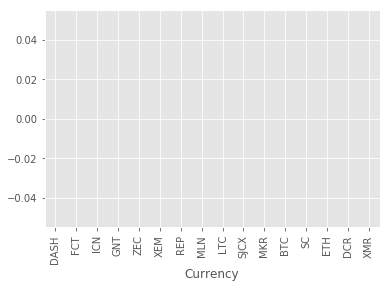

In [60]:
df['USD_Value'].plot(kind='bar')

In [61]:
df['pct'].plot(kind='pie')

KeyError: 'pct'